<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-4

### Библиотеки:

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## 1. Обучите CNN (самописная) на CIFAR-100.

### Загрузка данных

In [2]:
train_dataset = torchvision.datasets.CIFAR100(root='data/', 
                                 train=True, 
                                 transform=transforms.ToTensor(), 
                                 download=True)

Files already downloaded and verified


### Пример изображения

torch.Size([3, 32, 32])
86
telephone


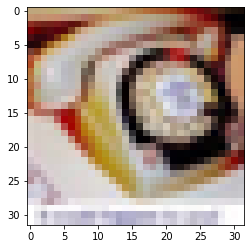

In [3]:
image, label = train_dataset[5]
print(image.size())
print(label)
print(train_dataset.classes[label])
plt.imshow(image.permute(1, 2, 0).numpy());

### DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           num_workers=2)

In [5]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', 
                                             train=False,
                                             download=True, 
                                             transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=1)

Files already downloaded and verified


### Net

In [6]:
class Net(nn.Module):

    def __init__(self, deep, hidden_channels, hidden_dim, dropout, negative_slope, glob_max_pool):
        super(Net, self).__init__()
        self.deep = deep
        self.glob_max_pool = glob_max_pool

        self.bn = nn.ModuleList()
        self.conv = nn.ModuleList()

        self.dp = nn.Dropout(dropout)
        self.lrelu = nn.LeakyReLU(negative_slope)

        self.conv.append(nn.Conv2d(3, hidden_channels, 3, padding=1))
        self.bn.append(nn.BatchNorm2d(hidden_channels))
        for i in range(deep-1): 
          self.conv.append(nn.Conv2d(hidden_channels*2**i, hidden_channels*2**(i+1), 3, stride=2, padding=1))
          self.bn.append(nn.BatchNorm2d(hidden_channels*2**(i+1)))
        if glob_max_pool:
          first_dim = hidden_channels*2**(deep-1)
        else:
          first_dim = hidden_channels*2**(11-deep)
        self.fc_1 = nn.Linear(first_dim, hidden_dim*2)
        self.bn_1 = nn.BatchNorm1d(hidden_dim*2)
        self.fc_2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn_2 = nn.BatchNorm1d(hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 100)
        
    def forward(self, x):

        for i in range(self.deep):
          x = self.conv[i](x)
          x = self.bn[i](x)
          x = self.lrelu(x)
          x = self.dp(x)

        if self.glob_max_pool:
          x = F.max_pool2d(x, 2**(6-self.deep))
          
        x = x.view(x.size(0), -1)
        
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.lrelu(x)
        x = self.dp(x)

        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.lrelu(x)
        x = self.dp(x)

        x = self.fc_3(x)
        return x

### Train Net

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
def net_train(net, train_loader, test_loader, num_epochs, lr, noise):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=lr)

  for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0

    for data in train_loader:

      inputs, labels = data[0].to(device), data[1].to(device)
      # Обнуляем градиент
      optimizer.zero_grad()
      # Делаем предсказание
      outputs = net(inputs)
      # Рассчитываем лосс-функцию
      loss = criterion(outputs, labels)
      # Делаем шаг назад по лоссу
      loss.backward()
      # Делаем шаг нашего оптимайзера
      optimizer.step()
      train_loss += loss.item()

    # Расчитываем loss на test
    for data in test_loader:
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

    # Расчитываем acc на test
      test_acc += (torch.max(outputs, 1)[1] == labels).sum().item() / len(labels)

    # выводим статистику о процессе обучения
    if noise:
      print(f'Epoch: {epoch + 1}; '\
            f'Train_loss: {round(train_loss / len(train_loader), 3)}; '\
            f'Test_loss: {round(test_loss / len(test_loader), 3)}; '\
            f'Test_acc: {round(test_acc / len(test_loader), 3)}')
  
  return net, round(test_acc / len(test_loader), 3)

### Best model

In [9]:
net = Net(deep=5, hidden_channels=50, hidden_dim=100, dropout=0.0, negative_slope=0.2, glob_max_pool=False).to(device)
print(net)
summary(net.to(device), input_size=(3, 32, 32))

Net(
  (bn): ModuleList(
    (0): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): ModuleList(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(50, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(100, 200, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(200, 400, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(400, 800, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (dp): Dropout(p=0.0, inplace=False)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (fc_1): Linear(in_features=3200, o

In [10]:
%%time

net = Net(deep=5, hidden_channels=50, hidden_dim=100, dropout=0.0, negative_slope=0.2, glob_max_pool=False).to(device)
net.train()

net, loss = net_train(net, train_loader, test_loader, num_epochs=20, lr=0.001, noise=True)

Epoch: 1; Train_loss: 3.555; Test_loss: 3.071; Test_acc: 0.249
Epoch: 2; Train_loss: 2.744; Test_loss: 2.613; Test_acc: 0.334
Epoch: 3; Train_loss: 2.309; Test_loss: 2.314; Test_acc: 0.393
Epoch: 4; Train_loss: 2.0; Test_loss: 2.169; Test_acc: 0.425
Epoch: 5; Train_loss: 1.75; Test_loss: 2.086; Test_acc: 0.444
Epoch: 6; Train_loss: 1.506; Test_loss: 2.121; Test_acc: 0.446
Epoch: 7; Train_loss: 1.256; Test_loss: 2.111; Test_acc: 0.468
Epoch: 8; Train_loss: 1.007; Test_loss: 2.205; Test_acc: 0.457
Epoch: 9; Train_loss: 0.775; Test_loss: 2.322; Test_acc: 0.459
Epoch: 10; Train_loss: 0.568; Test_loss: 2.493; Test_acc: 0.454
Epoch: 11; Train_loss: 0.398; Test_loss: 2.697; Test_acc: 0.449
Epoch: 12; Train_loss: 0.282; Test_loss: 2.865; Test_acc: 0.446
Epoch: 13; Train_loss: 0.225; Test_loss: 3.064; Test_acc: 0.441
Epoch: 14; Train_loss: 0.188; Test_loss: 3.216; Test_acc: 0.439
Epoch: 15; Train_loss: 0.184; Test_loss: 3.332; Test_acc: 0.439
Epoch: 16; Train_loss: 0.164; Test_loss: 3.384; Test

## 2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [11]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)
summary(resnet50.to(device), input_size=(3, 256, 256))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Замораживаем предтренированную модель

In [12]:
for param in resnet50.parameters():
    param.requires_grad = False

### Загрузим данные обработав их под предтренированную модель

In [13]:
train_dataset = torchvision.datasets.CIFAR100(root='data/', 
                                 train=True, 
                                 transform=transforms.Compose([transforms.Resize(256),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    std=[0.229, 0.224, 0.225])]), 
                                 download=True)
test_dataset = torchvision.datasets.CIFAR100(root='data/', 
                                 train=False, 
                                 transform=transforms.Compose([transforms.Resize(256),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    std=[0.229, 0.224, 0.225])]), 
                                 download=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=128, 
                                           shuffle=False,
                                          num_workers=1)

### Добавим к модели свой классификатор и обучим его

In [15]:
%%time

resnet50.fc = nn.Sequential(nn.Linear(2048, 100))
resnet50.train()

net, loss = net_train(resnet50.to(device), train_loader, test_loader, num_epochs=3, lr=0.001, noise=True)

Epoch: 1; Train_loss: 2.441; Test_loss: 1.837; Test_acc: 0.514
Epoch: 2; Train_loss: 1.652; Test_loss: 1.686; Test_acc: 0.537
Epoch: 3; Train_loss: 1.497; Test_loss: 1.61; Test_acc: 0.556
CPU times: user 12min 15s, sys: 32.4 s, total: 12min 47s
Wall time: 13min 16s


### 3. Вывод

Я написал свою сверточную сеть для задачи классификации данных CIFAR100.

Я использовал устоявшийся блок свёртки: conv -> bn -> lrelu -> drop.

Вместо Pool я использовал stride, чтобы облегчить модель.

С каждой следующей свёрткой я уменьшал размер изображения вдвое с помощью stride(кроме первой свётки), но при этом увеличивал количество карт признаков вдвое.

После выделения признаков скользящими окнами(свёртками), я использовал классификатор, предварительно выпряямив данные.

В классификаторе использовал схожий блок: lin -> bn -> lrelu -> drop.


Как оказалось, здесь dropout не помогает против переобучения, так как это уже делает BatchNorm, а просто замедляет обучение сети, поэтому его гиперпарамет 0.0

GlobalMaxPool оказался хуже выпрямления данных(flatten), даже когда карты признаков имеют размер 2х2(при deep=5). Видимо, факт того, что где то нет сигнала, а не только что он где то есть, несёт достаточно информации для улучшения метрики.

При обучении самописной модели, после 7 эпохи ошибка на тесте(test_loss) начинает расти, а метрика на тесте(test_acc) перестаёт меняться, хотя ошибка на train(loss_train) продолжает падать:

- Это связано с тем, что модель всё дальше учится, но после 7 эпохи, она перестаёт менять своё мнение, какая картика к какому классу относится, поэтому test_acc практически перестаёт меняться. 

- Модель чтобы уменьшить loss_train начинает давать более уверенные ответы, поэтому продолжает уменьшаться loss_train.

- Так как модель начинает давать более уверенные ответы на train, то и на test она начинает сильнее ошибаться, тоесть сами ответы не меняются, но модель начинает быть в них более уверенной и давать этим ответам большую вероятность(если смотреть уже после softmax), из-за этого увеличивается loss_test.

Это всё можно обобщить и назвать как переобучение после 7 эпохи. Модель перестаёт находить общие зависимости и начинает затачиваться под train примеры.


Дальше я использовал предобученную сеть resnet50. 

Для того, чтобы её коректно использовать, нужно подогнать свои данные под размер 256х256 и нормализвать их по 3 каналам со средним mean=[0.485, 0.456, 0.406] и со среднеквадратическим отклонением std=[0.229, 0.224, 0.225], так как все модели из torchvision.models были предобучены на ImageNet, где каждой картинке изменяли размер до 256х256, и данные имели именно такие статистические параметры.

Так как модель предобучена, то свёрточные слои уже умеют выделять информативные признаки для классификации и нам остаётся только обучить сам классификатор. В моём случае я использовал просто 1 полносвязный слой со 2048 входами и со 100 выходами. 

Сеть работает заметно дольше самописной, так как она гораздо больше и происходит очень много вычеслений.

Но уже после первой эпохи, метрика больше чем у самописной сети.

При этом после трёх эпох test_loss опускается, значит переобучение не наступило и у модели еще есть куда обучаться. Так же был использован самый простой классификатор в виде одного полносвязного слоя.

Значит гораздо лучше с точки зрения результата, неговоря уже о том, что обучать сеть из 25 млн параметров пришлось бы очень долго, использовать предобученные сети. Особенно это касается свёрточных сетей, так как выделяемые ею карты признаков более универсальны, а так же свёрточным сетям не важен входной размер изображения, что является еще одним плюсом в пользу использования предобученных свёрточных сетей.